# Курс Глубокое обучение в компьютерном зрении
# Урок 4. Семантическая сегментация

# Задание
Обучить модель семантической сегментации (человек-vs-фон) на подмножестве датасета MS COCO
Библиотеки: [Python, Tensorflow]

## Подключение библиотек и скриптов

In [ ]:
# For Google Colaboratory
%tensorflow_version 2.x

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import time

import os
import os.path
import skimage.io as io

import tensorflow as tf
import tensorflow_datasets as tfds

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
plt.rcParams.update({'font.size': 14})
pd.set_option('precision', 3)
pd.set_option('max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('max_colwidth', 300)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Функция визуализации графиков

In [ ]:
def plot_model(history): 
    fig, axs = plt.subplots(1, 2, figsize=(16, 5)) 
    # summarize history for accuracy
    axs[0].plot(history.history['accuracy'], 'c') 
    axs[0].plot(history.history['val_accuracy'],'m') 
    axs[0].set_title('Accuracy of epochs')
    axs[0].set_ylabel('Accuracy') 
    axs[0].set_xlabel('Epochs')
    axs[0].legend(['train', 'validate'], loc='upper left')
    # summarize history for loss
    axs[1].plot(history.history['loss'], 'c') 
    axs[1].plot(history.history['val_loss'], 'm') 
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss') 
    axs[1].set_xlabel('Epochs')
    axs[1].legend(['train', 'validate'], loc='upper left')
    plt.show()

## Загрузка датасета COCO и COCO API

In [ ]:
!mkdir -p data

In [ ]:
!cd data && wget http://images.cocodataset.org/zips/train2017.zip

--2021-07-27 13:14:08--  http://images.cocodataset.org/zips/train2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.1.212
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.1.212|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19336861798 (18G) [application/zip]
Saving to: ‘train2017.zip’

train2017.zip       100%[===================>]  18.01G  60.5MB/s    in 7m 8s   

2021-07-27 13:21:16 (43.1 MB/s) - ‘train2017.zip’ saved [19336861798/19336861798]



In [ ]:
!unzip /content/data/train2017.zip -d /content/drive/MyDrive/data/COCO/

Выходные данные были обрезаны до нескольких последних строк (5000).
 extracting: /content/drive/MyDrive/data/COCO/train2017/000000259556.jpg  
 extracting: /content/drive/MyDrive/data/COCO/train2017/000000381931.jpg  
 extracting: /content/drive/MyDrive/data/COCO/train2017/000000569592.jpg  
 extracting: /content/drive/MyDrive/data/COCO/train2017/000000229396.jpg  
 extracting: /content/drive/MyDrive/data/COCO/train2017/000000488990.jpg  
 extracting: /content/drive/MyDrive/data/COCO/train2017/000000348684.jpg  
 extracting: /content/drive/MyDrive/data/COCO/train2017/000000234031.jpg  
 extracting: /content/drive/MyDrive/data/COCO/train2017/000000563584.jpg  
 extracting: /content/drive/MyDrive/data/COCO/train2017/000000276069.jpg  
 extracting: /content/drive/MyDrive/data/COCO/train2017/000000401194.jpg  
 extracting: /content/drive/MyDrive/data/COCO/train2017/000000502089.jpg  
 extracting: /content/drive/MyDrive/data/COCO/train2017/000000192183.jpg  
 extracting: /content/drive/MyDr

In [ ]:
!cd data && wget http://images.cocodataset.org/zips/val2017.zip

--2021-07-27 11:01:32--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.77.60
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.77.60|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘val2017.zip’

val2017.zip         100%[===================>] 777.80M  83.5MB/s    in 9.9s    

2021-07-27 11:01:42 (78.2 MB/s) - ‘val2017.zip’ saved [815585330/815585330]



In [ ]:
!unzip /content/data/val2017.zip -d /content/drive/MyDrive/data/COCO/

Выходные данные были обрезаны до нескольких последних строк (5000).
 extracting: /content/drive/MyDrive/data/COCO/val2017/000000212226.jpg  
 extracting: /content/drive/MyDrive/data/COCO/val2017/000000231527.jpg  
 extracting: /content/drive/MyDrive/data/COCO/val2017/000000578922.jpg  
 extracting: /content/drive/MyDrive/data/COCO/val2017/000000062808.jpg  
 extracting: /content/drive/MyDrive/data/COCO/val2017/000000119038.jpg  
 extracting: /content/drive/MyDrive/data/COCO/val2017/000000114871.jpg  
 extracting: /content/drive/MyDrive/data/COCO/val2017/000000463918.jpg  
 extracting: /content/drive/MyDrive/data/COCO/val2017/000000365745.jpg  
 extracting: /content/drive/MyDrive/data/COCO/val2017/000000320425.jpg  
 extracting: /content/drive/MyDrive/data/COCO/val2017/000000481404.jpg  
 extracting: /content/drive/MyDrive/data/COCO/val2017/000000314294.jpg  
 extracting: /content/drive/MyDrive/data/COCO/val2017/000000335328.jpg  
 extracting: /content/drive/MyDrive/data/COCO/val2017/00

In [ ]:
!cd data && wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip 

--2021-07-27 11:07:03--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.70.220
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.70.220|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘annotations_trainval2017.zip’

annotations_trainva 100%[===================>] 241.19M  83.6MB/s    in 2.9s    

2021-07-27 11:07:07 (83.6 MB/s) - ‘annotations_trainval2017.zip’ saved [252907541/252907541]



In [ ]:
!unzip /content/data/annotations_trainval2017.zip -d /content/drive/MyDrive/data/COCO/

Archive:  /content/data/annotations_trainval2017.zip
  inflating: /content/drive/MyDrive/data/COCO/annotations/instances_train2017.json  
  inflating: /content/drive/MyDrive/data/COCO/annotations/instances_val2017.json  
  inflating: /content/drive/MyDrive/data/COCO/annotations/captions_train2017.json  
  inflating: /content/drive/MyDrive/data/COCO/annotations/captions_val2017.json  
  inflating: /content/drive/MyDrive/data/COCO/annotations/person_keypoints_train2017.json  
  inflating: /content/drive/MyDrive/data/COCO/annotations/person_keypoints_val2017.json  


In [ ]:
!cd data && unzip -q train2017.zip

In [ ]:
!cd data && git clone https://github.com/cocodataset/cocoapi
!cd data/cocoapi/PythonAPI && make

Cloning into 'cocoapi'...
remote: Enumerating objects: 975, done.
remote: Total 975 (delta 0), reused 0 (delta 0), pack-reused 975
Receiving objects: 100% (975/975), 11.72 MiB | 24.01 MiB/s, done.
Resolving deltas: 100% (576/576), done.
python setup.py build_ext --inplace
running build_ext
cythoning pycocotools/_mask.pyx to pycocotools/_mask.c
/usr/local/lib/python3.7/dist-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/data/cocoapi/PythonAPI/pycocotools/_mask.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
building 'pycocotools._mask' extension
creating build
creating build/common
creating build/temp.linux-x86_64-3.7
creating build/temp.linux-x86_64-3.7/pycocotools
x86_64-linux-gnu-gcc -pthread -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fdebug-prefix-map=/build/python3.7-LSlbJj/python3.7-3.7.11=. -fstack-protector-strong -Wformat -

In [ ]:
if 1:
    # !mkdir -p data

    # !cd data && wget http://images.cocodataset.org/zips/train2017.zip 
    !cd data && wget http://images.cocodataset.org/zips/val2017.zip 
    !cd data && wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip 

    # !cd data && unzip -q train2017.zip
    !cd data && unzip -q val2017.zip
    !cd data && unzip -q annotations_trainval2017.zip

    # !cd data && git clone https://github.com/cocodataset/cocoapi
    # !cd data/cocoapi/PythonAPI && make

--2021-07-27 13:04:52--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.161.113
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.161.113|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘val2017.zip’

val2017.zip         100%[===================>] 777.80M  75.8MB/s    in 9.4s    

2021-07-27 13:05:01 (82.5 MB/s) - ‘val2017.zip’ saved [815585330/815585330]

--2021-07-27 13:05:02--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.152.228
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.152.228|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘annotations_trainval2017.zip’

annotations_trainva 100%[===================>] 241.19M  78.5MB/s    in 3.1s    

20

In [ ]:
!cd /content/drive/MyDrive/data/COCO/ && git clone https://github.com/cocodataset/cocoapi
!cd /content/drive/MyDrive/data/COCO/cocoapi/PythonAPI && make

Cloning into 'cocoapi'...
remote: Enumerating objects: 975, done.
remote: Total 975 (delta 0), reused 0 (delta 0), pack-reused 975
Receiving objects: 100% (975/975), 11.72 MiB | 16.42 MiB/s, done.
Resolving deltas: 100% (576/576), done.
python setup.py build_ext --inplace
running build_ext
cythoning pycocotools/_mask.pyx to pycocotools/_mask.c
/usr/local/lib/python3.7/dist-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/drive/MyDrive/data/COCO/cocoapi/PythonAPI/pycocotools/_mask.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
building 'pycocotools._mask' extension
creating build
creating build/common
creating build/temp.linux-x86_64-3.7
creating build/temp.linux-x86_64-3.7/pycocotools
x86_64-linux-gnu-gcc -pthread -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fdebug-prefix-map=/build/python3.7-LSlbJj/python3.7-3.7.11=. -fstack-protecto

## Подготовка COCO API

In [ ]:
# COCO_ROOT = './data/'
COCO_ROOT = '/content/drive/MyDrive/data/COCO/'
import sys
sys.path.insert(0, os.path.join(COCO_ROOT, 'cocoapi/PythonAPI'))
from pycocotools.coco import COCO

## Универсальный класс Dataset для сегментации

In [ ]:
class Dataset():

    def crop_images(self, img, inp_size, random_crop=False):
        shape = tf.shape(img)
        pad = (
            [0, tf.maximum(inp_size - shape[0], 0)],
            [0, tf.maximum(inp_size - shape[1], 0)],
            [0, 0],
        )
        img = tf.pad(img, pad)

        if random_crop:
            img = tf.image.random_crop(img, (inp_size, inp_size, shape[2]))
        else: # central crop
            shape = tf.shape(img)
            ho = (shape[0] - inp_size) // 2
            wo = (shape[1] - inp_size) // 2
            img = img[ho:ho+inp_size, wo:wo+inp_size, :]

        return img

    def train_dataset(self, batch_size, epochs, inp_size):

        def item_to_images(item):
            random_crop = True
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            img_combined = self.crop_images(img_combined, inp_size, random_crop)

            img = tf.cast(img_combined[...,:3], tf.float32) / np.float32(255.)
            mask_class = tf.cast(img_combined[...,3:4], tf.float32)
            return img, mask_class

        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        dataset = dataset.shuffle(buffer_size=len(self.img_list))
        dataset = dataset.map(item_to_images)
        dataset = dataset.repeat(epochs)
        dataset = dataset.batch(batch_size, drop_remainder=True)

        return dataset

    def val_dataset(self, batch_size, inp_size):

        def item_to_images(item):
            random_crop = False
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            img_combined = self.crop_images(img_combined, inp_size, random_crop)

            img = tf.cast(img_combined[...,:3], tf.float32) / np.float32(255.)
            mask_class = tf.cast(img_combined[...,3:4], tf.float32)
            return img, mask_class

        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        dataset = dataset.map(item_to_images)
        dataset = dataset.batch(batch_size, drop_remainder=True)

        return dataset

## Класс для сегментационного датасета COCO
Класс наследутся от универсльного `Dataset` и реализует кастомную функцию чтения данных.

In [ ]:
class COCO_Dataset(Dataset):

    def __init__(self, sublist):
        ann_file_fpath = os.path.join(COCO_ROOT, 'annotations', 'instances_'+sublist+'2017.json')
        self.coco = COCO(ann_file_fpath)
        self.cat_ids = self.coco.getCatIds(catNms=['person'])
        self.img_list = self.coco.getImgIds(catIds=self.cat_ids)

    def read_images(self, img_id):
        img_id = int(img_id.numpy())
        img_data = self.coco.loadImgs(img_id)[0]
        img_fname = '/'.join(img_data['coco_url'].split('/')[-2:])

        img = io.imread(os.path.join(COCO_ROOT, img_fname))
        if len(img.shape) == 2:
            img = np.tile(img[..., None], (1, 1, 3))

        ann_ids = self.coco.getAnnIds(imgIds=img_data['id'], catIds=self.cat_ids, iscrowd=None)
        anns = self.coco.loadAnns(ann_ids)
        mask_class = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
        for i in range(len(anns)):
            mask_class += self.coco.annToMask(anns[i])
        mask_class = (mask_class > 0).astype(np.uint8)

        img_combined = np.concatenate([img, mask_class[..., None]], axis=2)

        return img_combined

In [ ]:
COCO_dataset_train = COCO_Dataset('train')
COCO_dataset_val = COCO_Dataset('val')

loading annotations into memory...
Done (t=19.62s)
creating index...
index created!
loading annotations into memory...
Done (t=3.15s)
creating index...
index created!


In [ ]:
INP_SIZE = 256
NUM_EPOCHS = 2
BATCH_SIZE = 32

train_ds = COCO_dataset_train.train_dataset(batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, inp_size=INP_SIZE)
test_ds = COCO_dataset_val.val_dataset(batch_size=BATCH_SIZE, inp_size=INP_SIZE)

In [ ]:
train_ds

<BatchDataset shapes: ((32, 256, 256, None), (32, 256, 256, None)), types: (tf.float32, tf.float32)>

In [ ]:
test_ds

<BatchDataset shapes: ((32, None, None, None), (32, None, None, None)), types: (tf.float32, tf.float32)>

In [ ]:
len(train_ds), len(test_ds)

(4007, 84)

## Визуализация датасета

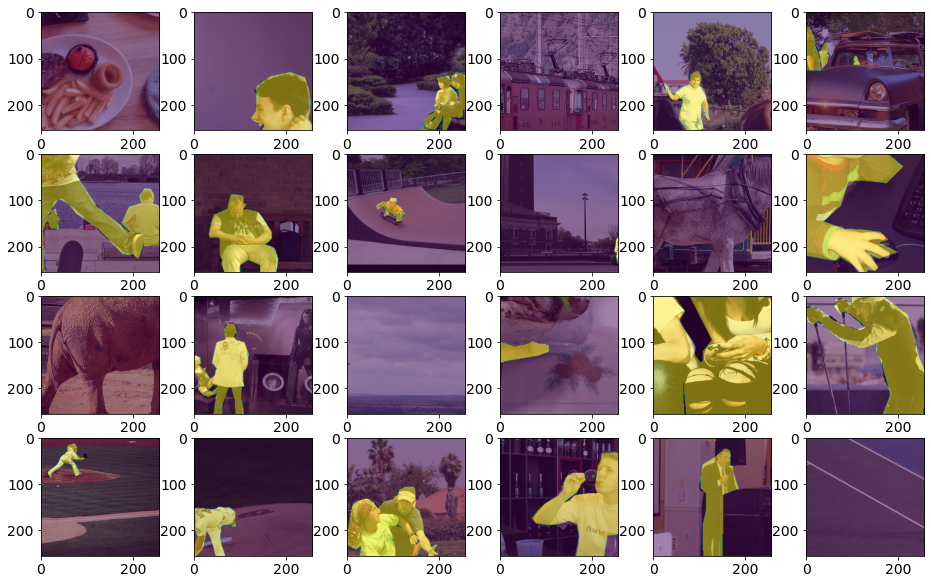

In [ ]:
image, mask = next(iter(train_ds.take(24)))

fig = plt.figure(figsize=(16, 10))
for i in range(24):
    ax = fig.add_subplot(4, 6, i+1)
    ax.imshow(image[i])
    ax.imshow(mask[i, ..., 0], alpha=0.5)
plt.show()

## Создание модели U-Net

In [ ]:
# U-Net
def build_model():
    x = tf.keras.layers.Input((256, 256, 3))
    
    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    out1 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out1)

    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out2 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out2)

    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out3 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out3)

    out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
    out4 = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out4)

    out = tf.keras.layers.Conv2D(1024, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(1024, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out4, out], axis=3)

    out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out3, out], axis=3)

    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out2, out], axis=3)

    out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out1, out], axis=3)

    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(1, (3, 3), padding='same', activation='sigmoid')(out)

    return tf.keras.Model(inputs=x, outputs=out)

model = build_model()

In [ ]:
LEARNING_RATE = 0.0001
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

model.compile(optimizer=optimizer,
              loss='BinaryCrossentropy', 
              metrics=['accuracy'])

In [ ]:
EXP_NAME = 'U-Net'

tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir='logs/'+EXP_NAME, 
    write_graph=False, update_freq=100, profile_batch=0)

## Контрольные точки

In [ ]:
checkpoint_path = '/content/drive/MyDrive/Colab Notebooks/116_ComputerView/less_04/hw_4/checkpointV'

ckpt = tf.train.Checkpoint(
    model=model,
    optimizer=optimizer
)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

## Обучение модели

Предыдущий код был выполнен в Google Colab на TPU, при подключении к которому предоставляется около 60 Гб на диске. При подключении в Google Colab к GPU предоставляется в два раза меньше места на диске, которого не хватает для разархивирования всех файлов датасета train2017. На Google Drive разархивировалось 105 из 118 тысяч файлов. Иная реализацияя загрузки файлов мной не написана. Без полного количества файлов датасета train2017 последующий код обучения модели не отрабатывается без ошибок.

In [ ]:
%%time

history = model.fit(train_ds, 
                          batch_size=BATCH_SIZE, 
                          epochs=1, 
                          validation_data=test_ds, 
                          callbacks=[tensorboard_callback]
                          )

ckpt_manager.save()

## Результат

In [ ]:
score_train = model.evaluate(train_ds, verbose=0)
score_test = model.evaluate(test_ds, verbose=0)

In [ ]:
result = pd.DataFrame((score_train[1], score_test[1], score_train[0], score_test[0])).T
result.columns=['train_accuracy', 'test_accuracy', 'train_loss', 'test_loss']
result['model'] = 'U-Net'

In [ ]:
result

In [ ]:
plot_model(history)

## TensorBoard

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs

## Запуск предсказания для случайного изображения

In [ ]:
import random

idx = random.randint(0, 100)

X_train, y_train = next(iter(train_ds.take(idx)))

In [ ]:
PERCEPTION = 0.5

In [ ]:
pred_prob = model(X_train[:4]).numpy()
pred_mask = (pred_prob[..., 0] > PERCEPTION).astype(np.float32)

for i in range(4):
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.title('True')
    plt.imshow(X_train[i])
    plt.imshow(y_train[i, ..., 0], alpha=0.5)
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.title('Predictions')
    plt.imshow(X_train[i])
    plt.imshow(pred_mask[i], alpha=0.5)
    plt.axis('off')

In [ ]:
idx = random.randint(0, 100)

X_test, y_test = next(iter(train_ds.take(idx)))

In [ ]:
pred_prob = model(X_test[:4]).numpy()
pred_mask = (pred_prob[..., 0] > PERCEPTION).astype(np.float32)

for i in range(4):
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.title('True')
    plt.imshow(X_test[i])
    plt.imshow(y_test[i, ..., 0], alpha=0.5)
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.title('Predictions')
    plt.imshow(X_test[i])
    plt.imshow(pred_mask[i], alpha=0.5)
    plt.axis('off')